In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import glob
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
!gsutil -mq cp gs://tibot-ml-labeling/datasets/cats_vs_dogs_dataset.zip '/content/drive/My Drive/'

#### Import Libraries

In [59]:
import os
from PIL import Image
from glob import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

In [4]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/Polyfins_works/")

In [ ]:
!ls

cats_vs_dogs_dataset  cats_vs_dogs_dataset.zip


In [66]:
# !unzip cats_vs_dogs_dataset.zip -d  cats_vs_dogs_dataset

In [ ]:
os.chdir("/content/drive/MyDrive/cats_vs_dogs_dataset/dataset")

In [ ]:
%ls

test/  train/


In [5]:
train_dir = "/kaggle/input/catvsdogs/dataset/train/"
test_dir = "/kaggle/input/catvsdogs/dataset/test/"

#### EDA

In [ ]:
%pwd

'/content/drive/MyDrive/cats_vs_dogs_dataset/dataset'

In [ ]:
img=Image.open("train/cats/cats3583.jpg")
width, height = img.size
print(width, height)

468 388


In [ ]:
# Aspect ratio
aspect_ratio = width / height
aspect_ratio

1.2061855670103092

In [ ]:
#calculate the coresponding height from that aspect ratio
int(width * aspect_ratio)

564

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# https://keras.io/api/data_loading/image

In [3]:
train_dataGen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1.0/255,
    fill_mode='nearest',
    validation_split=0.2,
)
test_dataGen = ImageDataGenerator(rescale=1./255)

**target_size** : Larger Input size will increase the computional demand on training and inference also check the image ratio and imformation gather from image than fixed the ratio.

In [18]:
train_generator = train_dataGen.flow_from_directory(
    train_dir,
    target_size =(224,224),
    batch_size = 64,
    class_mode ='sparse',
    subset='training',
    shuffle=True,
    seed=42,
    color_mode ='rgb'
)

validation_generator = train_dataGen.flow_from_directory(
    train_dir,
    target_size =(224,224),
    batch_size = 64,
    class_mode ='sparse',
    subset='validation',
    shuffle=False,
    seed=42,
    color_mode ='rgb'
)

test_generator = test_dataGen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=64,
    class_mode='sparse',
    shuffle=False
)

Found 14392 images belonging to 2 classes.
Found 3598 images belonging to 2 classes.
Found 4732 images belonging to 2 classes.


In [ ]:
#number of batch per epoch, samples, number of class, list of class labels,
len(train_generator), train_generator.samples, train_generator.num_classes, list(train_generator.class_indices.keys()), train_generator.image_shape, train_generator.batch_size

(450, 14392, 2, ['cats', 'dogs'], (224, 224, 3), 32)

#### InceptionV3 Model

In [ ]:
# https://keras.io/api/applications/#usage-examples-for-image-classification-models
# https://keras.io/api/applications/inceptionv3/
# https://keras.io/guides/transfer_learning/

In [7]:
InceptionV3=tf.keras.applications.InceptionV3(
    include_top =False,
    weights =None,
    input_shape =(224,224, 3)
    )
# InceptionV3.summary()

**Freeze** :
when not Using pretrained weight from ImageNet or anyother source it good to freeze the layer of the model on training set.Freeze the layer means pretrained weight of those layers not update during trainig and this done to prevent losing information. We know pretrained layer learn from large dataset so instead of focusing new layers it focused on the top layers.

In [8]:
incep_model = tf.keras.Sequential([
    InceptionV3,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256,  activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation="sigmoid")
])

In [82]:
incep_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_18 (Dense)            (None, 256)               524544    
                                                                 
 batch_normalization_379 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 2)                

In [9]:
# tf.keras.optimizers.Adam(learning_rate=0.001)
incep_model.compile(optimizer='adam', loss="sparse_categorical_crossentropy",metrics=['accuracy'])

In [10]:
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5,min_lr=0.002, verbose=1)   #newlr = lr* factor
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, verbose=1, mode="min", restore_best_weights=True)

In [ ]:
# os.makedirs("Models/Re/")

#### Save model On Drive and Google cloud

In [ ]:
class Model_saveDrive(Callback):
    def __init__(self, drive_dir,model):
        super(Model_saveDrive, self).__init__()
        self.drive_dir = drive_dir
        self.model = model

  # def set_model(self,model):
  #   self.model = incep_model

    def on_epoch_end(self,epoch, logs=None):
        model_filename=os.path.join(self.drive_dir,f'model_epoch_{epoch+1}.h5')
        self.model.save(model_filename, include_optimizer=True)
        !gsutil -mq cp {model_filename} gs://tibot-ml-labeling/models/cats_vs_dogs_task/gaju/InceptionV3/model/
        print(f"{model_filename} save in bucket")

In [ ]:
drive_dir = '/content/drive/MyDrive/Models/InceptionV3/'
save_model_callback = Model_saveDrive(drive_dir, incep_model)

In [11]:
epochs=20
incep_model.fit(train_generator, epochs=epochs, steps_per_epoch=len(train_generator),
          validation_data=validation_generator, validation_steps=len(validation_generator), callbacks=[lr, es])

Epoch 1/20
225/225 [==============================] - 385s 1s/step - loss: 0.5993 - accuracy: 0.7037 - val_loss: 1.4432 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - 254s 1s/step - loss: 0.5020 - accuracy: 0.7613 - val_loss: 1.2124 - val_accuracy: 0.5564 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - 256s 1s/step - loss: 0.4423 - accuracy: 0.8006 - val_loss: 0.7232 - val_accuracy: 0.7226 - lr: 0.0010
Epoch 4/20
225/225 [==============================] - 257s 1s/step - loss: 0.4138 - accuracy: 0.8152 - val_loss: 0.6528 - val_accuracy: 0.7126 - lr: 0.0010
Epoch 5/20
225/225 [==============================] - 254s 1s/step - loss: 0.3948 - accuracy: 0.8283 - val_loss: 0.5643 - val_accuracy: 0.7551 - lr: 0.0010
Epoch 6/20
225/225 [==============================] - 251s 1s/step - loss: 0.3959 - accuracy: 0.8297 - val_loss: 0.6307 - val_accuracy: 0.7535 - lr: 0.0010
Epoch 7/20
225/225 [==============================] - 250s 1s/st

In [16]:
loss, accuracy = incep_model.evaluate(test_generator, steps=len(test_generator))
print(loss, accuracy)

74/74 [==============================] - 45s 617ms/step - loss: 0.2232 - accuracy: 0.9068
0.2231939285993576 0.9068047404289246


In [50]:
class_labels = list(test_generator.class_indices.keys())
true_labels = test_generator.classes
predicions = incep_model.predict(test_generator, steps=len(test_generator))
predicted_labels =[np.argmax(prediction) for prediction in predicions]
classification_rep = classification_report(true_labels, predicted_labels, target_names=class_labels)
print("/n",classification_rep)

74/74 [==============================] - 16s 215ms/step
/n               precision    recall  f1-score   support

        cats       0.97      0.90      0.93      3505
        dogs       0.76      0.93      0.84      1227

    accuracy                           0.91      4732
   macro avg       0.87      0.92      0.89      4732
weighted avg       0.92      0.91      0.91      4732



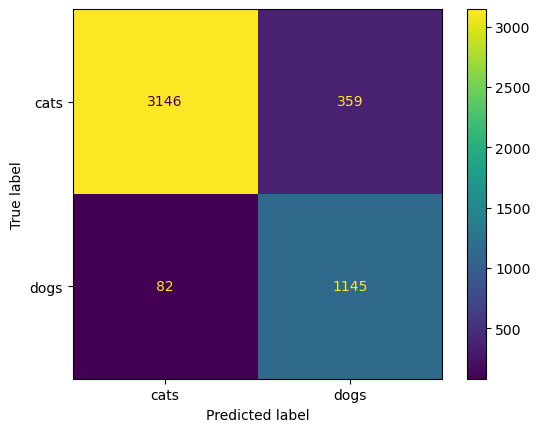

In [63]:
#Show with Confusion matrix
cm = confusion_matrix(true_labels, np.array(predicted_labels))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=class_labels)
cm_display.plot()
plt.show()

#### EffieicentNetV2 B2

In [64]:
effcient=tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights = 'imagenet',
    input_shape =(224,224, 3),
    classes=2,
)

In [65]:
x=effcient.output
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dropout(0.3)(x)  # add for reduce overfiting
predictions = tf.keras.layers.Dense(2, activation="sigmoid")(x)
eff_model= tf.keras.models.Model(inputs= effcient.input,outputs=predictions)

In [79]:
eff_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  0          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [66]:
eff_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [67]:
epochs=20
eff_model.fit(train_generator, epochs=epochs, steps_per_epoch=len(train_generator),
          validation_data=validation_generator, validation_steps=len(validation_generator), callbacks=[lr, es])

Epoch 1/20


2023-08-17 14:10:08.542618: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


225/225 [==============================] - 353s 1s/step - loss: 0.2093 - accuracy: 0.9118 - val_loss: 0.4508 - val_accuracy: 0.7779 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - 245s 1s/step - loss: 0.1170 - accuracy: 0.9561 - val_loss: 0.6398 - val_accuracy: 0.6506 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - 240s 1s/step - loss: 0.0930 - accuracy: 0.9650 - val_loss: 0.7219 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
225/225 [==============================] - 244s 1s/step - loss: 0.0873 - accuracy: 0.9658 - val_loss: 0.6970 - val_accuracy: 0.5008 - lr: 0.0010
Epoch 5/20
225/225 [==============================] - 245s 1s/step - loss: 0.0788 - accuracy: 0.9702 - val_loss: 0.7096 - val_accuracy: 0.4761 - lr: 0.0010
Epoch 6/20
225/225 [==============================] - 244s 1s/step - loss: 0.0687 - accuracy: 0.9745 - val_loss: 6.9892 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/20
225/225 [==============================] - 245s 1s/step - loss: 

In [74]:
loss, accuracy = eff_model.evaluate(test_generator, steps=len(test_generator))
print(loss, accuracy)

74/74 [==============================] - 21s 289ms/step - loss: 0.4853 - accuracy: 0.7301
0.4853411316871643 0.7301352620124817


In [75]:
class_labels = list(test_generator.class_indices.keys())
true_labels = test_generator.classes
predicions = eff_model.predict(test_generator, steps=len(test_generator))
predicted_labels =[np.argmax(prediction) for prediction in predicions]
classification_rep = classification_report(true_labels, predicted_labels, target_names=class_labels)
print("/n",classification_rep)

74/74 [==============================] - 16s 189ms/step
/n               precision    recall  f1-score   support

        cats       0.97      0.66      0.78      3505
        dogs       0.49      0.93      0.64      1227

    accuracy                           0.73      4732
   macro avg       0.73      0.80      0.71      4732
weighted avg       0.84      0.73      0.75      4732



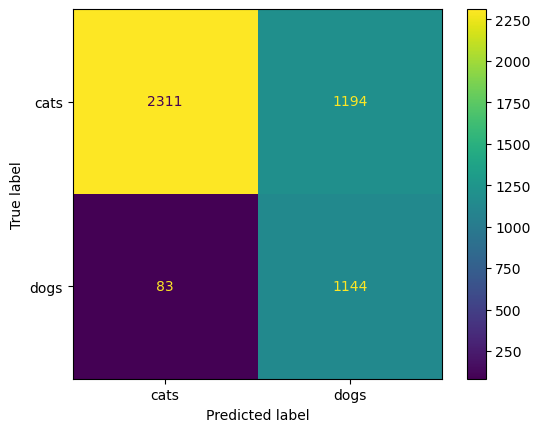

In [76]:
cm = confusion_matrix(true_labels, np.array(predicted_labels))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=class_labels)
cm_display.plot()
plt.show()

#### Simple Customs Model

In [ ]:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [69]:
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, MaxPooling2D, Conv2D
from tensorflow.keras import Sequential

In [72]:
customs = Sequential()
customs.add(Conv2D(32,(3, 3), padding='same', input_shape=(224,224,3)))
customs.add(Activation('relu'))
customs.add(MaxPooling2D(pool_size=(2,2)))

customs.add(Conv2D(32, (3, 3), padding='same'))
customs.add(Activation('relu'))
customs.add(MaxPooling2D(pool_size=(2, 2)))


customs.add(Conv2D(64, (3, 3), padding='same'))
customs.add(Activation('relu'))
customs.add(MaxPooling2D(pool_size=(2, 2)))

customs.add(Conv2D(32, (3, 3), padding='same'))
customs.add(Activation('relu'))
customs.add(MaxPooling2D(pool_size=(2, 2)))


customs.add(Flatten())
customs.add(Dense(512))
customs.add(Activation('relu'))
customs.add(Dropout(0.5))
customs.add(Dense(2))
customs.add(Activation('sigmoid'))

customs.compile(optimizer='adam',loss="sparse_categorical_crossentropy",metrics=['accuracy'])
customs.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_97 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 activation_99 (Activation)  (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_98 (Conv2D)          (None, 112, 112, 32)      9248      
                                                                 
 activation_100 (Activation)  (None, 112, 112, 32)     0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [71]:
customs.fit(train_generator, epochs=20, steps_per_epoch=len(train_generator),
          validation_data=validation_generator, validation_steps=len(validation_generator), callbacks=[lr, es])

Epoch 1/20


2023-08-17 15:07:12.958985: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


225/225 [==============================] - 236s 1s/step - loss: 1.0906 - accuracy: 0.5060 - val_loss: 0.6931 - val_accuracy: 0.5042 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - 233s 1s/step - loss: 0.6932 - accuracy: 0.4924 - val_loss: 0.6930 - val_accuracy: 0.5097 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - 230s 1s/step - loss: 0.6932 - accuracy: 0.4926 - val_loss: 0.6932 - val_accuracy: 0.5003 - lr: 0.0010
Epoch 4/20
225/225 [==============================] - 232s 1s/step - loss: 0.6930 - accuracy: 0.5024 - val_loss: 0.6911 - val_accuracy: 0.5003 - lr: 0.0010
Epoch 5/20
225/225 [==============================] - 228s 1s/step - loss: 0.6940 - accuracy: 0.5164 - val_loss: 0.6933 - val_accuracy: 0.5003 - lr: 0.0010
Epoch 6/20
225/225 [==============================] - 230s 1s/step - loss: 0.6933 - accuracy: 0.4949 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/20
225/225 [==============================] - 238s 1s/step - loss: 

In [80]:
customs.evaluate(test_generator, steps=len(test_generator))

74/74 [==============================] - 15s 199ms/step - loss: 0.6346 - accuracy: 0.7392


[0.6346327066421509, 0.7392222881317139]

In [77]:
class_labels = list(test_generator.class_indices.keys())
true_labels = test_generator.classes
predicions = customs.predict(test_generator, steps=len(test_generator))
predicted_labels =[np.argmax(prediction) for prediction in predicions]
classification_rep = classification_report(true_labels, predicted_labels, target_names=class_labels)
print("/n",classification_rep)

74/74 [==============================] - 15s 202ms/step
/n               precision    recall  f1-score   support

        cats       0.74      1.00      0.85      3505
        dogs       0.29      0.00      0.01      1227

    accuracy                           0.74      4732
   macro avg       0.52      0.50      0.43      4732
weighted avg       0.62      0.74      0.63      4732



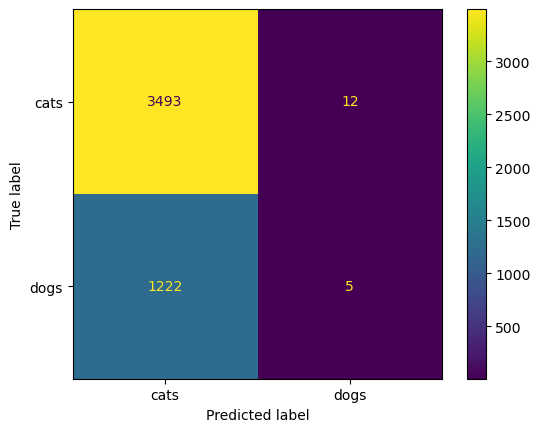

In [78]:
cm = confusion_matrix(true_labels, np.array(predicted_labels))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=class_labels)
cm_display.plot()
plt.show()

#### Accuracy and loss of each model

| Model| Accuracy |loss|
| ----- | ----- |-----|
|InceptionV3|0.90680|0.223|
|EfficinetNetV2-B2|0.730135|0.4853|
|Customs|0.7392|0.6346|